# 10. TCGA Pan-cancer RNA-seq analysis

[Gene expression data](https://xenabrowser.net/datapages/?dataset=GDC-PANCAN.htseq_fpkm.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443) and [basic metadata](https://xenabrowser.net/datapages/?dataset=GDC-PANCAN.basic_phenotype.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443) were accessed using the UCSC Xena database.

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
import scipy.sparse as sp
from scipy.stats import pearsonr
import os
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

sc.set_figure_params(figsize=(10, 4), dpi_save=600)

## 0. Read in & format counts and metadata

In [2]:
counts = '/path/to/GDC-PANCAN.htseq_fpkm.tsv'
meta = '/path/to/GDC-PANCAN.basic_phenotype.tsv'

In [3]:
expr = pd.read_csv(
   counts,
    sep="\t",
    index_col=0,
    low_memory=False
)

In [4]:
manifest = pd.read_csv(
    meta,
    sep="\t",
    header=0
)

In [5]:
expr.shape

(60483, 11057)

In [6]:
manifest.shape

(19188, 7)

## 1. Remove TARGET dataset samples

In [7]:
cancers = [cancer for cancer in manifest.project_id.value_counts().index if cancer.startswith('TCGA')]

In [8]:
len(cancers)

33

In [9]:
# filter metadata
meta_filt = manifest[manifest['project_id'].isin(cancers)]

In [10]:
meta_filt.shape

(14318, 7)

In [11]:
common_samples = expr.columns.intersection(meta_filt['sample'])

In [12]:
len(common_samples)

11057

In [13]:
expr_filt = expr[common_samples]

## 2. Convert into AnnData object

In [14]:
# set sample as the index
if 'sample' in meta_filt.columns:
    meta_filt_indexed = meta_filt.set_index('sample', drop=False)
else:
    meta_filt_indexed = meta_filt.copy()

# Keep only samples shared by expression and metadata
common_samples = expr.columns.intersection(meta_filt_indexed.index)

# 3. subset & align both tables in the same order
expr_sub = expr.reindex(columns=common_samples)
meta_sub = meta_filt_indexed.reindex(index=common_samples)

print(f"Keeping {expr_sub.shape[1]} samples and {expr_sub.shape[0]} genes")
print(meta_sub.shape)

# create AnnData
adata = ad.AnnData(
    X=expr_sub.T.values,               # samples × genes
    obs=meta_sub,                      # DataFrame indexed by sample
    var=pd.DataFrame(index=expr_sub.index)  # gene metadata
)

Keeping 11057 samples and 60483 genes
(11057, 7)


In [15]:
adata

AnnData object with n_obs × n_vars = 11057 × 60483
    obs: 'sample', 'program', 'sample_type_id', 'sample_type', 'project_id', 'Age at Diagnosis in Years', 'Gender'

## 3. Replace gene id with gene symbol

In [16]:
# genes are listed as ensembl IDs, so we will need to convert to gene symbols 
adata.var

""
Ensembl_ID
ENSG00000242268.2
ENSG00000270112.3
ENSG00000167578.15
ENSG00000273842.1
ENSG00000078237.5
...
ENSG00000105063.17
ENSG00000231119.2
ENSG00000280861.1


In [18]:
# Load gtf file
gtf = pd.read_csv(
    "/path/to/gencode.v38.annotation.gtf.gz",
    sep="\t",
    comment="#",
    header=None,
    names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"]
)

# keep only "gene" feature
genes = gtf[gtf["feature"] == "gene"]

# extract gene_id
genes["gene_id"] = genes["attributes"].str.extract(r'gene_id "([^"]+)"')
genes["gene_symbol"] = genes["attributes"].str.extract(r'gene_name "([^"]+)"')

# drop version suffix 
genes["gene_id"] = genes["gene_id"].str.replace(r"\..*", "", regex=True)

# create map
gene_map = genes.set_index("gene_id")["gene_symbol"].to_dict()

/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/1198528812.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes["gene_id"] = genes["attributes"].str.extract(r'gene_id "([^"]+)"')
/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/1198528812.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes["gene_symbol"] = genes["attributes"].str.extract(r'gene_name "([^"]+)"')
/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/1198528812.py:18: SettingWithCopyWarn

In [19]:
# strip version suffix in var_names in adata
adata.var_names = adata.var_names.str.replace(r"\..*", "", regex=True)

# map to gene symbols
adata.var["gene_symbol"] = adata.var_names.map(gene_map)

# Remove any NA, then make symbols unique
adata = adata[:, adata.var["gene_symbol"].notna()].copy()
adata.var_names = adata.var["gene_symbol"]
adata.var_names_make_unique()


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [20]:
# remove col header from index
if adata.var.index.name == "gene_symbol":
    adata.var.index.name = None 

In [21]:
# looks good

adata.var

,gene_symbol
LINC02082,LINC02082
ST8SIA5-DT,ST8SIA5-DT
RAB4B,RAB4B
TIGAR,TIGAR
RNF44,RNF44
...,...
RP11-713D19.1,RP11-713D19.1
PPP6R1,PPP6R1
RP4-569M23.2,RP4-569M23.2
BATF3,BATF3


In [22]:
# ensure project_id is a string (somtimes this gives saving errors)

adata.obs['project_id'] = (
    adata.obs['project_id']
    .astype(str) 
    .str.replace(r'^TCGA-', '', regex=True)
)

In [23]:
# save anndata object

#adata.write_h5ad('tcga_pancan.h5ad')

## 4. Score gene sets

In [24]:
# define gene sets

icb_res = [
    "PRSS27", "ELF3", "DESI1", "LTF", "PGLYRP4", "PDZK1IP1", "SPNS2", "PSCA", "PRSS22", "TMPRSS11G",
    "GSTO1", "KRT19", "MUC20", "TSPAN1", "DUOXA2", "TMEM242", "TMC5", "ECM1", "CBLC", "CCDC129", 
    "PRSS27P", "CAPN5", "GLRX", "SPNS3", "TMPRSS11E", "ZSCAN32", "TP53INP2", "SLC6A14", "DYNAP", 
    "DUSP4", "CLDN23", "CCDC69", "CLIC5", "GRPEL2", "APOL7B", "GDE1", "MAL", "DUOX2", "NUPR1", 
    "CLDN1", "P2RY2", "IRF7", "S100A14", "CDKN2B", "MALL", "PLEKHS1", "AC168977.1", "MUC4", "FXYD4", 
    "LY6G6D", "TRIM15", "MAL2", "WNT7B", "IFT22", "PLET1", "PPBP", "HIST1H1C", "CRYBA4", "KRT7", "HSD17B7", 
    "CLCA1", "TMPRSS11F", "SERPINB9", "CCDC186", "MYZAP", "SLC9A3R1", "PTTG1IP", "SLC28A3", "CIDEA", 
    "TMEM190", "PCDH11Y", "ARG1", "4930459C07RIK", "BSPRY", "CCDC12", "PIGR", "KRT23", "1810044K17RIK", 
    "CYP2D6", "PBP2", "CXCL5", "TMPRSS4", "LPCAT4", "CCDC71L", "ARHGAP27OS1", "EPS8L2", "TMPRSS11B", 
    "SERPINB9", "CSF3", "IFIT1", "LIPH", "EPHB3", "AA986860", "LGALS3", "RASSF7", "GRHL1", 
    "GFPT1", "TRIM16", "SPRR2D"
]

ifn_resp = [
    "GBP6", "GBP2", "IIGP1", "CNTN1", "TMEM226", "OR56A4", "MILL1", "CXCL10", "GBP4", "IFIT3", 
    "APOL10", "IFI47", "GBP5", "SLCO2A1", "PRL", "GREB1L", "GBP8", "CCL7", "TMEM121", "ZBED2", 
    "APOL9", "GPR176", "ADGRB3", "PRL", "CCL2", "RGS4", "IFIT1", "SERPINA3", "IRF1", "ASIC2", 
    "CXCL9", "MS4A4A", "IFIH1", "ZBTB8B", "ALOX12", "NRG1", "GHR", "GRIN2D", "CLIC4", "ROBO2", 
    "CCDC166", "LAMA3", "FAM126A", "ERLIN2", "GNB4", "AMMECR1", "ZC3H12C", "PRL", "SAMD5", 
    "FCGBP", "PLCB1", "FLNB", "CYP7B1", "IL24", "ALOX15", "IFIT3", "NCAM1", "CSPR2", "CD44", 
    "IL18R1", "SERPINB2", "EFEMP1", "TENM1", "CCL8", "SLC6A4", "HAS2", "UBD", "NPPB", "CCL11", 
    "FAP", "PCDH7", "IGFN1", "IFI16", "TNC", "MAJIN", "CSMD1", "ROBO1", "VCAM1", "IRF7", 
    "ZC3H12A", "NPAS3", "ITGB6", "DCLK1", "NEK10", "LY75", "CFAP47", "SLC4A7", "VEGFC", 
    "CNGA1", "HCN1", "SYT1", "SLCO1A2", "GDNF", "TENM3", "ERC1", "SKINT3", "PDLIM1", 
    "DNAH8", "CSNK1G3", "TNIP3"
]

neutro_chemo = ["CXCL1","CXCL2","CXCL3","CXCL5","CXCL8"]

neutros = [ 
    'LCN2', 'CD177', 'CEACAM8', 'MMP8', 'LTF', 'OLFM4', 'ARG2', 'SPP1', 'VEGFA', 
    'CD274', 'IL10'
]

cd8 = [
    'GZMB', 'GZMA', 'PRF1', 'GNLY', 'IFNG', 'CD8A', 'CD8B', 'PDCD1', 'TOX', 'IL2', 
    'CD69', 'CTLA4', 'TIGIT', 'LAMP1'
]

In [25]:
# score gene sets

sc.tl.score_genes(adata, gene_list=icb_res, score_name='ICB_RES')
sc.tl.score_genes(adata, gene_list=ifn_resp, score_name='IFN_RESP')
sc.tl.score_genes(adata, gene_list=neutro_chemo, score_name='neutro_chemo')
sc.tl.score_genes(adata, gene_list=neutros, score_name='neutros')
sc.tl.score_genes(adata, gene_list=cd8, score_name='cd8')

       '4930459C07RIK', '1810044K17RIK', 'PBP2', 'ARHGAP27OS1', 'AA986860'],
      dtype='object')
       'CSPR2', 'SKINT3'],
      dtype='object')


/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/4242962401.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/4242962401.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/4242962401.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


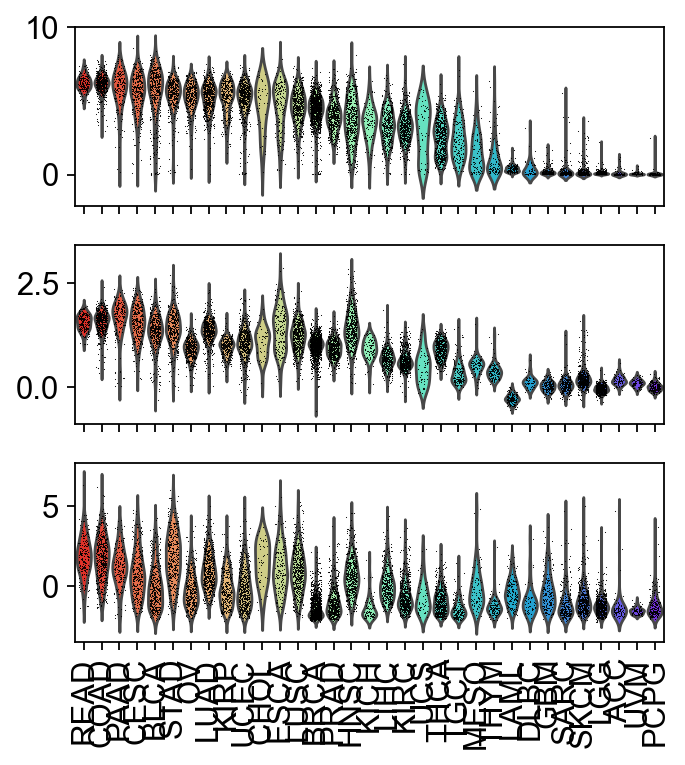

In [26]:
# violin plots for ELF3, ICB-res, and Neutrophil chemotaxis signatures ranked by their ELF3 expression

# order by mean ELF3 expression
elf3_mat = adata[:, "ELF3"].X
if sp.issparse(elf3_mat):
    elf3_vals = elf3_mat.toarray().flatten()
else:
    elf3_vals = np.asarray(elf3_mat).flatten()

df_elf3 = pd.DataFrame({
    "project_id": adata.obs["project_id"].values,
    "ELF3": elf3_vals
})
mean_elf3 = (
    df_elf3
    .groupby("project_id", observed=True)["ELF3"]
    .mean()
    .sort_values(ascending=False)
)
order = mean_elf3.index.tolist()

# create rainbow palette
palette = sns.color_palette("rainbow_r", n_colors=len(order))
pal = {proj: to_hex(c) for proj, c in zip(order, palette)}

# define scores to plot
scores = ["ELF3", "ICB_RES", "neutro_chemo"]
titles = ["ELF3 expression", "ICB_RES score", "Neutrophil‐chemo score"]

# create plot
fig, axes = plt.subplots(3, 1, figsize=(4.5, 5), sharex=True)
# use ELF3 gene expression for ELF3, otherwise default to the corresponding gene set score
for ax, score, title in zip(axes, scores, titles):

    if score == "ELF3":
        # use per-tumor ELF3 expression value
        df = df_elf3.rename(columns={"ELF3": score})
        # or use score in adata.obs
    else:
        df = (
            adata.obs
                .loc[:, ["project_id", score]]
                .dropna()
                .rename(columns={score: score})
        )
    # create violin plot with overlayed stripplot
    sns.violinplot(
        data=df,
        x="project_id",
        y=score,
        order=order,
        palette=pal,
        inner=None,
        ax=ax
    )
    sns.stripplot(
        data=df,
        x="project_id",
        y=score,
        order=order,
        color="k",
        size=0.5,
        jitter=0.3,
        alpha=1,
        ax=ax
    )
    # format axes
    ax.grid(False)
    ax.set_xlabel("")  # we'll set shared xlabel at bottom
    ax.set_ylabel("")  # you can uncomment to show per‐plot label

# formatting for entire figure

plt.xticks(rotation=90)
plt.tight_layout(h_pad=1.0)

#plt.savefig("stacked_scores_by_project.png", dpi=600)
plt.show()


/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_67752/3229532164.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


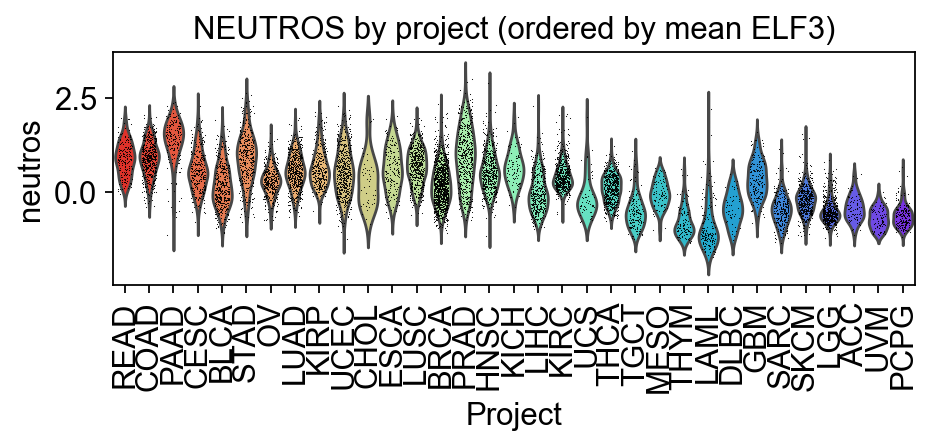

In [27]:
# create plot for neutrophil infiltration signature (tumors ranked by ELF3 expression)

# extract per‐tumor ELF3 expression
elf3_mat = adata[:, "ELF3"].X
if sp.issparse(elf3_mat):
    elf3_vals = elf3_mat.toarray().flatten()
else:
    elf3_vals = np.asarray(elf3_mat).flatten()

# create dataframe to get project means
df_elf3 = pd.DataFrame({
    "project_id": adata.obs["project_id"].values,
    "ELF3":        elf3_vals
})

# compute mean ELF3 expression per tumor and sort in descending order
mean_elf3 = (
    df_elf3
    .groupby("project_id", observed=True)["ELF3"]
    .mean()
    .sort_values(ascending=False)
)
order = mean_elf3.index.tolist()

# create rainbow palette
palette = sns.color_palette("rainbow_r", n_colors=len(order))
color_dict = {proj: to_hex(col) for proj, col in zip(order, palette)}

# score neutrophil signature
new_score = "neutros"

df_plot = (
    adata.obs
    .loc[:, ["project_id", new_score]]
    .dropna()
)

# make plot
plt.figure(figsize=(6, 3))
sns.violinplot(
    data=df_plot,
    x="project_id",
    y=new_score,
    order=order,
    palette=color_dict,
    inner=None
)
sns.stripplot(
    data=df_plot,
    x="project_id",
    y=new_score,
    order=order,
    color="k",
    size=.5,
    jitter=0.3,
    alpha=1
)
# format axes

plt.xticks(rotation=90)
plt.title(f"{new_score.upper()} by project (ordered by mean ELF3)")
plt.xlabel("Project")
plt.ylabel(new_score)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Neutros_ELF3order.png', dpi=600)
plt.show()


In [38]:
# perform statistical comparisons for each program score between epithelial and non-epithelial tumors 
# define epithelial cancer types
epi_cancers = [
    "READ", "COAD", "PAAD", "CESC", "BLCA", "STAD", "OV", "LUAD", "KIRP", "UCEC", 
    "CHOL", "ESCA", "LUSC", "BRCA", "PRAD", "HNSC", "KICH", "LIHC", "KIRC", "UCS", 
    "THCA"
]

# subset non-epithelial cancers from the dataset
all_projects = adata.obs["project_id"].unique().tolist()
non_epi_cancers = [p for p in all_projects if p not in epi_cancers]

# scores to compare
scores = ["ELF3", "ICB_RES", "neutro_chemo","neutros"]

# calculate p vals from t test
results = []

for score in scores:
    # get data
    if score == "ELF3":
        data = df_elf3.copy()
    else:
        data = adata.obs[["project_id", score]].dropna().copy()

    # split by group
    epi_vals = data[data["project_id"].isin(epi_cancers)][score].values
    non_epi_vals = data[data["project_id"].isin(non_epi_cancers)][score].values

    # perform t-test
    t_stat, p_val = ttest_ind(epi_vals, non_epi_vals, equal_var=False)

    # collect
    results.append({
        "score": score,
        "t_stat": t_stat,
        "p_val": p_val,
        "epi_mean": np.mean(epi_vals),
        "non_epi_mean": np.mean(non_epi_vals)
    })

# multiple testing correction
p_vals = [r["p_val"] for r in results]
_, adj_pvals, _, _ = multipletests(p_vals, method="fdr_bh")

# update results with corrected p-values
for r, adj_p in zip(results, adj_pvals):
    r["adj_p_val"] = adj_p

# compile as dataframe
df_results = pd.DataFrame(results)
df_results

,score,t_stat,p_val,epi_mean,non_epi_mean,adj_p_val
0,ELF3,169.325498,0.0,4.555793,0.421419,0.0
1,ICB_RES,148.568262,0.0,1.134709,0.107019,0.0
2,neutro_chemo,43.435028,0.0,0.072257,-1.011218,0.0
3,neutros,74.386835,0.0,0.491001,-0.413204,0.0


## 5. Plot correlation between ELF3 and ICB-resistance in all epithelial cancers

In [28]:
# since we are correlating ELF3 expression with the ICB-resistance signature, we will remove ELF3 from the
# signature to avoid introducing bias
icb_res_no_elf = [
    "PRSS27", "DESI1", "LTF", "PGLYRP4", "PDZK1IP1", "SPNS2", "PSCA", "PRSS22", "TMPRSS11G",
    "GSTO1", "KRT19", "MUC20", "TSPAN1", "DUOXA2", "TMEM242", "TMC5", "ECM1", "CBLC", "CCDC129", 
    "PRSS27P", "CAPN5", "GLRX", "SPNS3", "TMPRSS11E", "ZSCAN32", "TP53INP2", "SLC6A14", "DYNAP", 
    "DUSP4", "CLDN23", "CCDC69", "CLIC5", "GRPEL2", "APOL7B", "GDE1", "MAL", "DUOX2", "NUPR1", 
    "CLDN1", "P2RY2", "IRF7", "S100A14", "CDKN2B", "MALL", "PLEKHS1", "AC168977.1", "MUC4", "FXYD4", 
    "LY6G6D", "TRIM15", "MAL2", "WNT7B", "IFT22", "PLET1", "PPBP", "HIST1H1C", "CRYBA4", "KRT7", "HSD17B7", 
    "CLCA1", "TMPRSS11F", "SERPINB9", "CCDC186", "MYZAP", "SLC9A3R1", "PTTG1IP", "SLC28A3", "CIDEA", 
    "TMEM190", "PCDH11Y", "ARG1", "4930459C07RIK", "BSPRY", "CCDC12", "PIGR", "KRT23", "1810044K17RIK", 
    "CYP2D6", "PBP2", "CXCL5", "TMPRSS4", "LPCAT4", "CCDC71L", "ARHGAP27OS1", "EPS8L2", "TMPRSS11B", 
    "SERPINB9", "CSF3", "IFIT1", "LIPH", "EPHB3", "AA986860", "LGALS3", "RASSF7", "GRHL1", 
    "GFPT1", "TRIM16", "SPRR2D"
]

In [29]:
# score signature

sc.tl.score_genes(adata, gene_list=icb_res_no_elf, score_name='icb_res_no_elf')

       '4930459C07RIK', '1810044K17RIK', 'PBP2', 'ARHGAP27OS1', 'AA986860'],
      dtype='object')


In [30]:
# reset Matplotlib and Seaborn params for clean output
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"]  = 42
plt.rcParams["savefig.transparent"] = False
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

sns.set_theme(style="white", context="notebook") 

Pearson r = 0.63, p = 0.00e+00


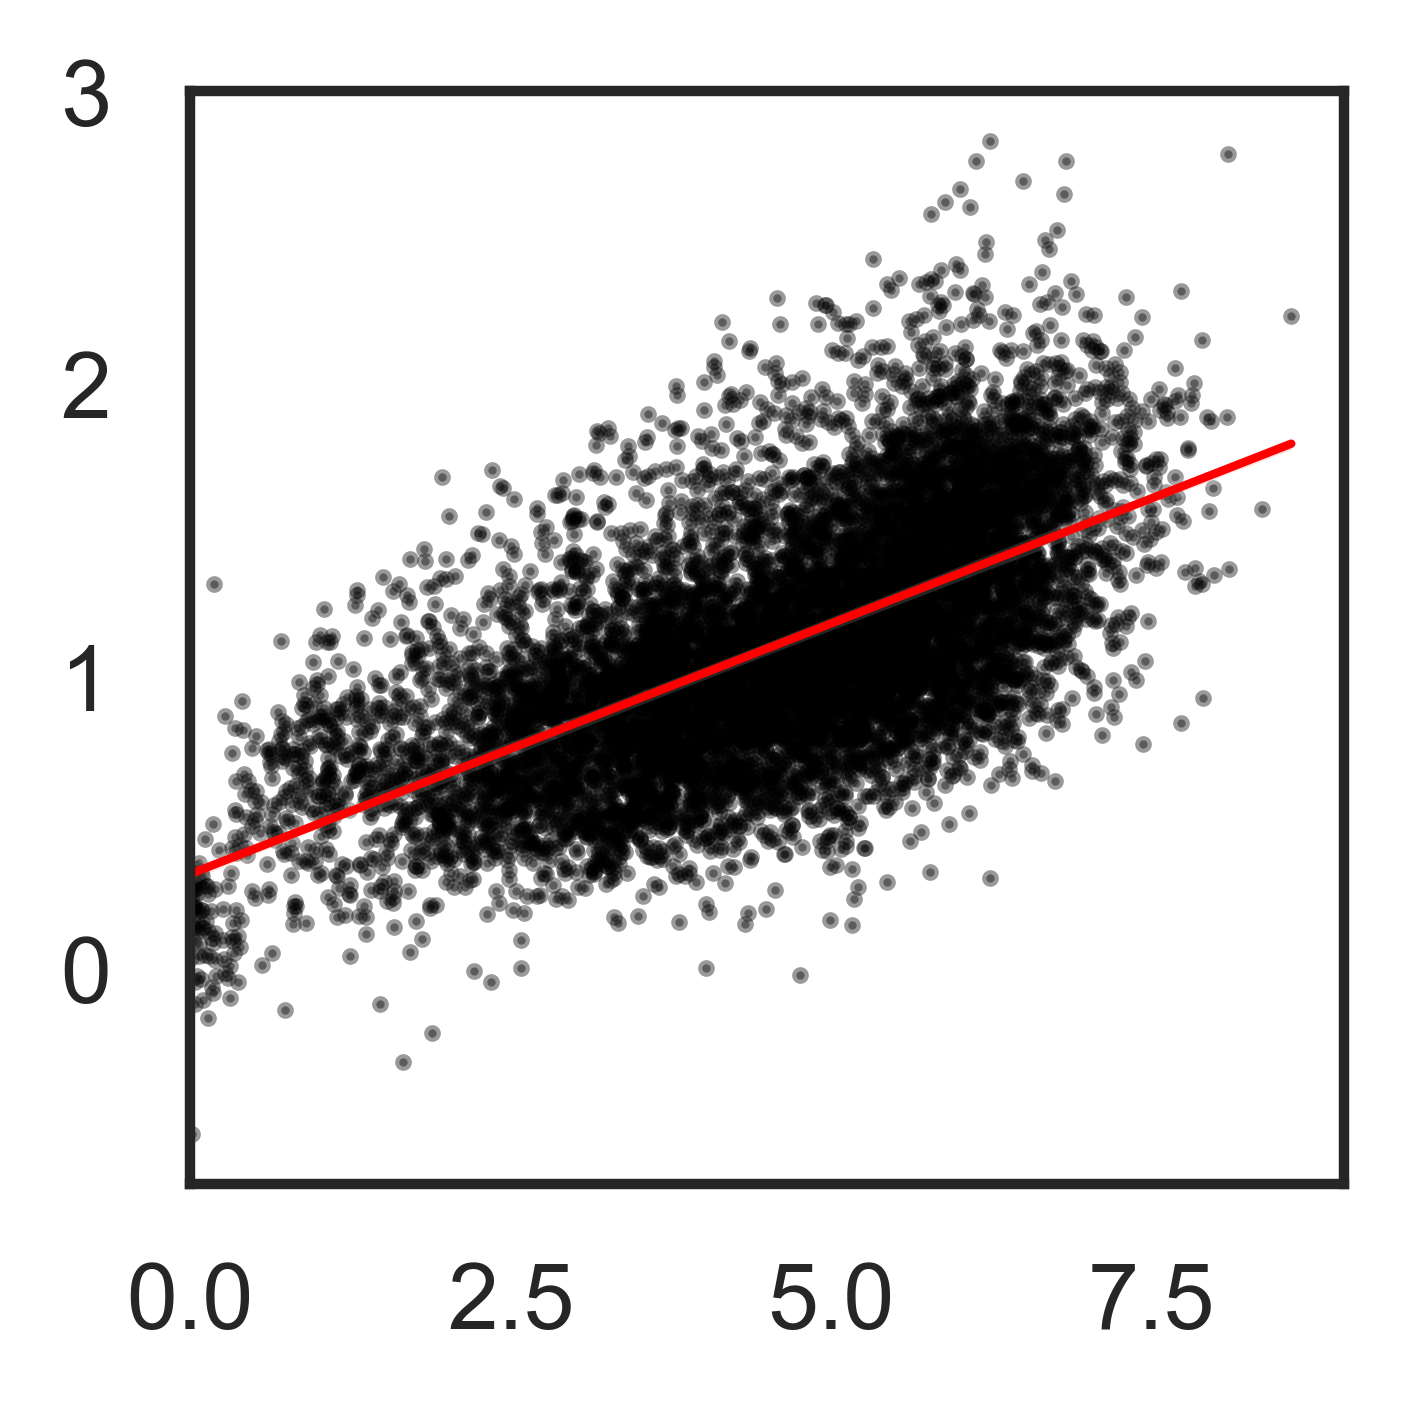

In [31]:
# plot correlation between ELF3 and ICB-resistance scores for all epithelial tumors together

# subset to only epithelial cancers
cancers_of_interest = ["READ", "COAD", "PAAD", "CESC", "BLCA", "STAD", "OV", "LUAD", "KIRP", "UCEC", 
                       "CHOL", "ESCA", "LUSC", "BRCA", "PRAD", "HNSC", "KICH", "LIHC", "KIRC", "UCS", 
                       "THCA"]

# create copy of adata
obs_full = adata.obs.copy()

# assign ELF3 expression as an entry in adata.obs
elf3_idx = adata.var.index[adata.var["gene_symbol"] == "ELF3"][0]
x_elf3   = adata[:, elf3_idx].X
x_elf3   = x_elf3.toarray().ravel() if sp.issparse(x_elf3) else x_elf3.ravel()
adata.obs["ELF3_expr"] = pd.Series(x_elf3, index=adata.obs_names)

obs_full["ELF3_expr"] = adata.obs["ELF3_expr"]

# subset to only epithelial cancers
df_all = obs_full[obs_full["project_id"].isin(cancers_of_interest)].dropna(subset=["ELF3_expr", "ICB_RES"])

# calculate Pearson correlation
r, p = pearsonr(df_all["ELF3_expr"], df_all["icb_res_no_elf"])
print(f"Pearson r = {r:.2f}, p = {p:.2e}")

# plot
plt.figure(figsize=(2.5, 2.5))
sns.regplot(
    data=df_all,
    x="ELF3_expr",
    y="icb_res_no_elf",
    scatter=True,
    scatter_kws={"s": 1, "alpha": 0.4, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
    ci=95
)
# format
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.xlim(0, 9)
plt.tight_layout()
#plt.savefig("ELF3_ICBres_corr_epi.png", dpi = 600)
plt.show()


## 6. Create heatmap for correlations for all epithelial cancers

In [33]:
# heatmap values are pearson correlation coefficients with significance overlayed
# as asterisks

# keep only cancers with at least 15 tumors
# configure output file location
MIN_SAMPLES = 15
OUT_DIR     = "elf3_cancer_heatmap"
os.makedirs(OUT_DIR, exist_ok=True)
# define signatures to be correalted with ELF3 expression
sig_list = ["ICB_RES", "IFN_RESP", "neutros", "cd8"]

# extract ELF3 expression
elf3_idx = adata.var.index[adata.var["gene_symbol"] == "ELF3"][0]
x_elf3   = adata[:, elf3_idx].X
x_elf3   = x_elf3.toarray().ravel() if sp.issparse(x_elf3) else x_elf3.ravel()
adata.obs["ELF3_expr"] = pd.Series(x_elf3, index=adata.obs_names)

# make sure no columns are missing
req_cols = ["project_id", "ELF3_expr"] + sig_list
missing  = [c for c in req_cols if c not in adata.obs.columns]
if missing:
    raise KeyError(f"Missing: {missing}")
# create separate obs dataframe
obs = adata.obs[req_cols].dropna().apply(pd.to_numeric, errors="ignore")

# now restrict analysis to only epithelial cancers
cancers_of_interest = ["READ", "COAD", "PAAD", "CESC", "BLCA", "STAD", "OV", "LUAD", "KIRP", "UCEC", 
                      "CHOL", "ESCA", "LUSC", "BRCA", "PRAD", "HNSC", "KICH", "LIHC", "KIRC", "UCS", 
                      "THCA"]
# subset
obs = obs[obs["project_id"].isin(cancers_of_interest)].copy()

# compute correlations and p-values
records = []
for cancer, df in obs.groupby("project_id"):

    if len(df) < MIN_SAMPLES:
        continue

    for sig in sig_list:
        rho, p = pearsonr(df["ELF3_expr"], df[sig])
        records.append(dict(project_id=cancer,
                            signature=sig,
                            rho=rho,
                            p_raw=p,
                            n=len(df)))

corr_df = pd.DataFrame.from_records(records)

# correct for multiple comparisons
corr_df["p_adj"] = multipletests(corr_df["p_raw"], method="fdr_bh")[1]

# build heatmap as 2 dataframes (one for pearsons rho and one for p vals)
# define column order for heatmap
col_order = ["ICB_RES", "neutros", "IFN_RESP", "cd8"]

# assign values as pearson's rho
rho_mat = (
    corr_df.pivot(index="project_id", columns="signature", values="rho")
           .reindex(columns=col_order)
)
# assign values to p-vals
padj_mat = (
    corr_df.pivot(index="project_id", columns="signature", values="p_adj")
           .reindex(columns=col_order)
)

# order rows by ascending CD8 correlation

composite = -rho_mat["cd8"]
ordered_projects = composite.sort_values(ascending=False).index

rho_mat  = rho_mat.loc[ordered_projects]
padj_mat = padj_mat.loc[ordered_projects]

# create heatmap annotation matrix
def stars(p):
    return "***" if p < .001 else "**" if p < .01 else "*" if p < .05 else ""

annot = rho_mat.copy().astype(str)
for i in rho_mat.index:
    for j in rho_mat.columns:
        annot.loc[i, j] = f"{stars(padj_mat.loc[i, j])}"

# create heatmap
fig, ax = plt.subplots(figsize=(4, 0.25 * len(rho_mat)))
sns.heatmap(rho_mat,
            cmap="vlag", center=0,
            annot=annot, fmt='',
            annot_kws={"fontsize": 8},
            cbar_kws={"label": "Pearson r"},
            linewidths=0,  # no borders
            ax=ax)

# format
ax.set_title("ELF3 expression correlations", pad=14)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
# save
#plt.savefig(f"{OUT_DIR}/ELF3_heatmap_ranked.pdf")
plt.close()

# save the correlation table as csv file
corr_df.to_csv(f"{OUT_DIR}/ELF3_correlations_full.csv", index=False)

/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_7345/3661361105.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  obs = adata.obs[req_cols].dropna().apply(pd.to_numeric, errors="ignore")
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.canvas.draw()
